## Importing packages and reading dataset for modeling

In [1]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role
import pandas as pd
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from io import StringIO
from sklearn.preprocessing import MinMaxScaler, Binarizer
import warnings; warnings.simplefilter('ignore')


pd.options.display.max_columns = 500 ## Enabling display of all columns in pandas output

bucket_crime ='mpls-crime-data' # bucket that contains the dataset for modeling
data_key = 'data_with_sentiment.csv'
data_location = 's3://{}/{}'.format(bucket_crime, data_key)
data = pd.read_csv(data_location)
data = data.drop(columns=['DATE','Date'])

print(data.shape)
data.head()

(1692, 15)


,PRCP,SNOW,SNWD,TAVG,ReportedDate,Precinct,count_incidents,PositiveWeight_mean,PositiveWeight_count,NegativeWeight_mean,NegativeWeight_count,NeutralWeight_mean,NeutralWeight_count,MixedWeight_mean,MixedWeight_count
0,0.0,0.0,0.0,8.0,2019-01-01,1,8,0.55729,2,0.000234,2,0.442473,2,0.000002,2
1,0.0,0.0,0.0,8.0,2019-01-01,2,9,0.55729,2,0.000234,2,0.442473,2,0.000002,2
2,0.0,0.0,0.0,8.0,2019-01-01,3,11,0.55729,2,0.000234,2,0.442473,2,0.000002,2
3,0.0,0.0,0.0,8.0,2019-01-01,4,7,0.55729,2,0.000234,2,0.442473,2,0.000002,2
4,0.0,0.0,0.0,8.0,2019-01-01,5,6,0.55729,2,0.000234,2,0.442473,2,0.000002,2


We create a column for prevailing sentiment using the maximum value of all the weights in our dataset. We call this column `PrevailingSentiment` (we removed `MixedWeight` from our dataset since it was negligible throughout and did not add value to the sentiment of a tweet).

In [2]:
data["ReportedDate"] = pd.to_datetime(data["ReportedDate"])

data.drop(columns=['MixedWeight_mean', 'MixedWeight_count'], inplace=True)

data_sorted = data.sort_values(['Precinct', 'ReportedDate'])
data_sorted['PrevailingSentiment'] = data_sorted[['PositiveWeight_mean', 'NegativeWeight_mean', 'NeutralWeight_mean']].max(axis=1)
data_sorted.head()

,PRCP,SNOW,SNWD,TAVG,ReportedDate,Precinct,count_incidents,PositiveWeight_mean,PositiveWeight_count,NegativeWeight_mean,NegativeWeight_count,NeutralWeight_mean,NeutralWeight_count,PrevailingSentiment
0,0.0,0.0,0.0,8.0,2019-01-01,1,8,0.557290,2,0.000234,2,0.442473,2,0.557290
5,0.0,0.0,0.0,11.0,2019-01-02,1,6,0.539049,7,0.026817,7,0.434122,7,0.539049
10,0.0,0.0,0.0,28.0,2019-01-03,1,8,0.245447,5,0.048752,5,0.705790,5,0.705790
15,0.0,0.0,0.0,36.0,2019-01-04,1,13,0.355797,11,0.041894,11,0.602304,11,0.602304
20,0.0,0.0,0.0,37.0,2019-01-05,1,11,0.035891,6,0.001074,6,0.963030,6,0.963030


We do the same for the count of tweets column.

In [3]:
senti = data_sorted[['PositiveWeight_mean', 'NegativeWeight_mean', 'NeutralWeight_mean']].idxmax(axis=1)
data_sorted['Sentiment'] = senti
data_sorted['Sentiment'] = data_sorted['Sentiment'].apply(lambda x: re.sub('Weight_mean','',x))
data_sorted['PrevailingSentiment_count'] = data_sorted[['PositiveWeight_count', 'NegativeWeight_count', 'NeutralWeight_count']].max(axis=1)
senti_count = data_sorted[['PositiveWeight_count', 'NegativeWeight_count', 'NeutralWeight_count']].idxmax(axis=1)
data_sorted['SentimentCount'] = senti_count
data_sorted.head()

,PRCP,SNOW,SNWD,TAVG,ReportedDate,Precinct,count_incidents,PositiveWeight_mean,PositiveWeight_count,NegativeWeight_mean,NegativeWeight_count,NeutralWeight_mean,NeutralWeight_count,PrevailingSentiment,Sentiment,PrevailingSentiment_count,SentimentCount
0,0.0,0.0,0.0,8.0,2019-01-01,1,8,0.557290,2,0.000234,2,0.442473,2,0.557290,Positive,2,PositiveWeight_count
5,0.0,0.0,0.0,11.0,2019-01-02,1,6,0.539049,7,0.026817,7,0.434122,7,0.539049,Positive,7,PositiveWeight_count
10,0.0,0.0,0.0,28.0,2019-01-03,1,8,0.245447,5,0.048752,5,0.705790,5,0.705790,Neutral,5,PositiveWeight_count
15,0.0,0.0,0.0,36.0,2019-01-04,1,13,0.355797,11,0.041894,11,0.602304,11,0.602304,Neutral,11,PositiveWeight_count
20,0.0,0.0,0.0,37.0,2019-01-05,1,11,0.035891,6,0.001074,6,0.963030,6,0.963030,Neutral,6,PositiveWeight_count


Intuitively, it occurred to us that the sentiment of a given day is unlikely to have a high correlation with any incidents on the same day. As a result, we created another set of columns as `LaggedXYZ` which indicates the attribute values of tweets from the previous day.

In [4]:
data_sorted.drop(columns=['PositiveWeight_mean', 'PositiveWeight_count',
       'NegativeWeight_mean', 'NegativeWeight_count', 'NeutralWeight_mean',
       'NeutralWeight_count','SentimentCount'],inplace=True)
data_sorted['LaggedSentiment'] = data_sorted.groupby(['Precinct'])['PrevailingSentiment'].shift(1)
data_sorted['LaggedSentimentValue'] = data_sorted.groupby(['Precinct'])['Sentiment'].shift(1)
data_sorted['LaggedSentimentCount'] = data_sorted.groupby(['Precinct'])['PrevailingSentiment_count'].shift(1)

data_sorted.head()

,PRCP,SNOW,SNWD,TAVG,ReportedDate,Precinct,count_incidents,PrevailingSentiment,Sentiment,PrevailingSentiment_count,LaggedSentiment,LaggedSentimentValue,LaggedSentimentCount
0,0.0,0.0,0.0,8.0,2019-01-01,1,8,0.557290,Positive,2,NaN,NaN,NaN
5,0.0,0.0,0.0,11.0,2019-01-02,1,6,0.539049,Positive,7,0.557290,Positive,2.0
10,0.0,0.0,0.0,28.0,2019-01-03,1,8,0.705790,Neutral,5,0.539049,Positive,7.0
15,0.0,0.0,0.0,36.0,2019-01-04,1,13,0.602304,Neutral,11,0.705790,Neutral,5.0
20,0.0,0.0,0.0,37.0,2019-01-05,1,11,0.963030,Neutral,6,0.602304,Neutral,11.0


In [5]:
## renaming the columns in our dataset

data_sorted.columns = ['PRCP', 'SNOW', 'SNWD', 'TAVG', 'ReportedDate', 'Precinct',
       'count_incidents', 'SentimentWeight', 'Sentiment',
       'Sentiment_count', 'LaggedSentimentWeight', 'LaggedSentiment',
       'LaggedSentimentCount']

As a final step and with an effort towards increasing the richness of our dataset, we added a final set of predictors in the form of poverty in a precinct and the topic distribution in our tweets.

In [6]:
data_sorted = data_sorted[~data_sorted['Precinct'].str.contains('UI')]
data = data_sorted.copy()

bucket_crime ='mpls-crime-data' # Replace with your s3 bucket name
data_key = 'poverty_small.csv'
data_location = 's3://{}/{}'.format(bucket_crime, data_key)
poverty_data = pd.read_csv(data_location)

## Dropping the index column
poverty_data = poverty_data.drop(columns='Unnamed: 0')

print(poverty_data.shape)
poverty_data.head()
data = pd.merge(data, poverty_data, left_on = 'Precinct', right_on = 'precinct')

(6, 3)


The topic distribution, like the tweets, is at a daily level, i.e. the prevalent topics for each day's tweets.

In [7]:
bucket_tweets ='socialmediaanalyticsblogpost-tweetsbucket-vhbpuflisv15' # Replace with your s3 bucket name
data_key = 'date_topicdistribution.csv'
data_location = 's3://{}/{}'.format(bucket_tweets, data_key)
tweets = pd.read_csv(data_location, encoding='latin-1', error_bad_lines=False)
tweets['Date'] = pd.to_datetime(tweets['Date'])
data = pd.merge(data, tweets, how='left', left_on='ReportedDate', right_on='Date')

In [9]:
data

,PRCP,SNOW,SNWD,TAVG,ReportedDate,Precinct,count_incidents,SentimentWeight,Sentiment,Sentiment_count,LaggedSentimentWeight,LaggedSentiment,LaggedSentimentCount,precinct,Poverty_Count,Poverty_Under_18,Date,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19
0,0.00,0.0,0.0,8.0,2019-01-01,1,8,0.557290,Positive,2,NaN,NaN,NaN,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00,0.0,0.0,11.0,2019-01-02,1,6,0.539049,Positive,7,0.557290,Positive,2.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00,0.0,0.0,28.0,2019-01-03,1,8,0.705790,Neutral,5,0.539049,Positive,7.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00,0.0,0.0,36.0,2019-01-04,1,13,0.602304,Neutral,11,0.705790,Neutral,5.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,0.0,0.0,37.0,2019-01-05,1,11,0.963030,Neutral,6,0.602304,Neutral,11.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.00,0.0,0.0,30.0,2019-01-06,1,7,0.430604,Positive,4,0.963030,Neutral,6.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.00,0.0,0.0,38.0,2019-01-07,1,11,0.489219,Neutral,11,0.430604,Positive,4.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.00,0.0,0.0,31.0,2019-01-08,1,14,0.543885,Neutral,8,0.489219,Neutral,11.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.00,0.0,0.0,11.0,2019-01-09,1,12,0.707740,Neutral,10,0.543885,Neutral,8.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.00,0.0,0.0,15.0,2019-01-10,1,8,0.633805,Neutral,14,0.707740,Neutral,10.0,1,1.783853e+06,62896.115282,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In time series modeling, it is a rule of thumb that the lagged values of the response variable will be a good explainer of the response itself. Thus, we calculate the exponential moving average of the response variable (in addition to the variables we already have).

As we have mentioned in our presentation, the lagged value of incident counts taken in themselves yield only around 50% accuracy. Our goal was to add more predictive power on top of this using the other features that we have talked about so far.

In [34]:
data['expwighted_avg'] = data.ewm(halflife=2)['count_incidents'].mean()

In [35]:
## We bring all the following columns on the same scale (since the range of magnitude of snow is going to be starkly different
## from that of temperature or number of people)

data_to_scale = data[['PRCP', 'SNOW', 'SNWD', 'TAVG', 'Poverty_Count','Poverty_Under_18']]
data = data.drop(columns = ['PRCP', 'SNOW', 'SNWD', 'TAVG', 'Poverty_Count','Poverty_Under_18'])


## we use the MinMaxScaler from sklearn to scale values in between 0 and 1
scaler = MinMaxScaler()
num_cols = data_to_scale.columns[data_to_scale.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
data_to_scale[num_cols] = scaler.fit_transform(data_to_scale[num_cols])

data = pd.concat([data, data_to_scale], 1)

# Make precinct categorical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['Precinct'] = le.fit_transform(data['Precinct'])
data.head()

# One-Hot Encoding Sentiment and LaggedSentiment
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

data[['Neutral','Positive']] = pd.get_dummies(data['Sentiment'])
data[['Lagged_Neutral','Lagged_Positive']] = pd.get_dummies(data['LaggedSentiment'])
data = data.drop(columns=['Sentiment', 'LaggedSentiment'])

data[['Sentiment_count']] = scaler.fit_transform(data[['Sentiment_count']])
data[['LaggedSentimentCount']] = scaler.fit_transform(data[['LaggedSentimentCount']])

data = data.drop(columns=['precinct', 'Date'])

## Modeling using Xgboost

Since we are dealing with time-series data, the splitting will be done based on date. We choose 8 months of training data and 4 months for testing

In [40]:
data["ReportedDate"] = pd.to_datetime(data["ReportedDate"])

split_date = '2019-08-31'
train = data[data['ReportedDate'] <= split_date]
test = data[data['ReportedDate'] > split_date]

## since the prediction of count is going to be per-day at a precinct level we make a multi-level index
train.set_index(['Precinct', 'ReportedDate'], inplace=True)
test.set_index(['Precinct', 'ReportedDate'], inplace=True)

X_train = train.drop(columns=['count_incidents'])
y_train = train[['count_incidents']]

X_test = test.drop(columns=['count_incidents'])
y_test = test[['count_incidents']]

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')



## --------- Nested cross validaton on Xgboost regressor with 500 weak learners ----------------
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error

reg = xgb.XGBRegressor(n_estimators=500)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

### -----------------------------------------
param_grid = {
 'max_depth':range(3,5,2),
 'min_child_weight':range(3,7,2)}

inner_cv = KFold(n_splits=2, shuffle=True, random_state=45)
outer_cv = KFold(n_splits=2, shuffle=True, random_state=45)

grid_tree = GridSearchCV(reg, param_grid, cv = inner_cv, verbose=True, scoring='neg_mean_squared_error')
grid_tree.fit(X_train,y_train, verbose=True)

# Nested CV with parameter optimization
nested_score = cross_val_score(grid_tree, X_train, y_train, cv=outer_cv,verbose=True)

# Training based on the estimator
final_model = grid_tree.best_estimator_

[00:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.8147	validation_1-rmse:13.6403
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10.7293	validation_1-rmse:12.3653
[2]	validation_0-rmse:9.76112	validation_1-rmse:11.2451
[3]	validation_0-rmse:8.89708	validation_1-rmse:10.2251
[4]	validation_0-rmse:8.12592	validation_1-rmse:9.33604
[5]	validation_0-rmse:7.44151	validation_1-rmse:8.53182
[6]	validation_0-rmse:6.83582	validation_1-rmse:7.82654
[7]	validation_0-rmse:6.29891	validation_1-rmse:7.20137
[8]	validation_0-rmse:5.82626	validation_1-rmse:6.6658
[9]	validation_0-rmse:5.4097	validation_1-rmse:6.20339
[10]	validation_0-rmse:5.04606	validation_1-rmse:5.8244
[11]	validation_0-rmse:4.72682	validation_1-rmse:5.49112
[12]	validation_0-rmse:4.4511	validation_1-

[00:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.8s finished


[00:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[00:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s finished


[00:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[00:34:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s finished


[00:34:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s finished


In [42]:
final_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,
       verbose=False)

[00:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

Unsurprisingly, the weighted moving average happens to be the best explainer. But, as mentioned before, the lagged sentiment attributes and the current sentiment attributes are the next most important features. To visualize how our model performs, we plotted the actual incidents data alongside our predictions

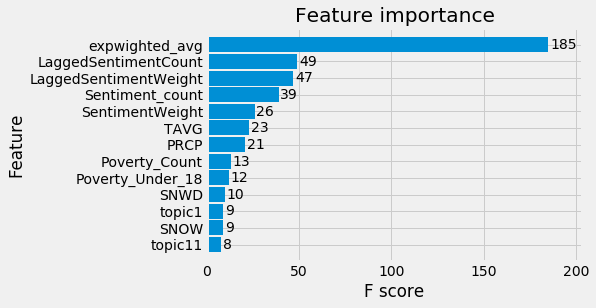

In [66]:
ax = plot_importance(final_model, height=0.9, max_num_features=13, ylabel='Feature')

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800.]), <a list of 10 Text xticklabel objects>)

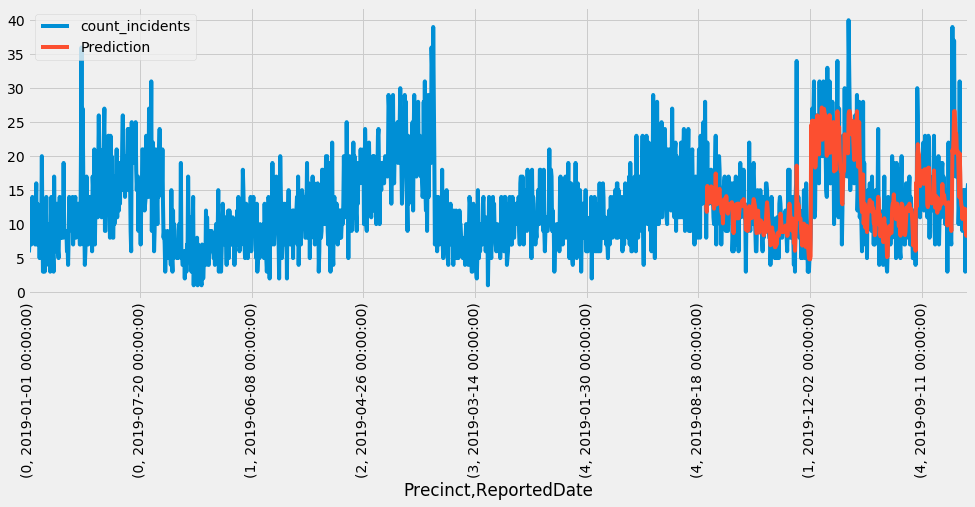

In [54]:
test['Prediction'] = final_model.predict(X_test)
all_data = pd.concat([train,test], sort=False)

all_data[['count_incidents','Prediction']].plot(figsize=(15, 5))
plt.xticks(rotation=90)

In [60]:
csv_buffer = StringIO()
all_data.to_csv(csv_buffer, index=False)

# Upload CSV to S3
s3_key = 'All_Data_Predicted_For_Chart.csv'
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket_crime, s3_key).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'D3DC0725A4715DB7',
  'HostId': 'ZsyTMaJ8aGsUWDZlw4liq5/pFrjpDySjSzFOPqCsbvBURWkCV30ZszpwsSfqwc4X/m4UjL49MQ0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ZsyTMaJ8aGsUWDZlw4liq5/pFrjpDySjSzFOPqCsbvBURWkCV30ZszpwsSfqwc4X/m4UjL49MQ0=',
   'x-amz-request-id': 'D3DC0725A4715DB7',
   'date': 'Mon, 09 Dec 2019 00:56:19 GMT',
   'etag': '"519ceee90d74aae40b824b30a14f64e6"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"519ceee90d74aae40b824b30a14f64e6"'}

And thus, we were able to up the accuracy of 50% to 75%! Below we publish the metrics (MAPE and MSE) on both the training and test set.

In [55]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


train['Prediction'] = final_model.predict(X_train)

## MAPE calculation on train and test set
print(mean_absolute_percentage_error(y_true=test['count_incidents'],
                   y_pred=test['Prediction']))

print(mean_absolute_percentage_error(y_true=train['count_incidents'],
                   y_pred=train['Prediction']))


## MSE calculation on train and test set
print(mean_squared_error(y_true=test['count_incidents'],
                   y_pred=test['Prediction']))

print(mean_squared_error(y_true=train['count_incidents'],
                   y_pred=train['Prediction']))

25.294988082204334
23.08268352521578
14.92395179848431
8.394703491439017


The following section was used to create a dataset with a reduced number of columns to make the time-lapse on Tableau.

In [56]:
new_test = test.reset_index()
new_test['error'] = new_test['count_incidents'] - new_test['Prediction']
new_test['abs_error'] = new_test['error'].apply(np.abs)

error_by_day = new_test.groupby(['ReportedDate', 'Precinct']) \
    .mean()[['count_incidents','Prediction','error','abs_error']]

# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

,,count_incidents,Prediction,error,abs_error
ReportedDate,Precinct,,,,
2019-09-01,2,12,24.587040,-12.587040,12.587040
2019-11-10,2,15,26.021786,-11.021786,11.021786
2019-09-07,2,11,21.347059,-10.347059,10.347059
2019-10-20,2,11,20.785414,-9.785414,9.785414
2019-11-27,2,11,20.565212,-9.565212,9.565212
2019-11-23,2,12,20.921717,-8.921717,8.921717
2019-11-16,4,10,17.818972,-7.818972,7.818972
2019-10-12,2,10,17.759726,-7.759726,7.759726
2019-09-28,2,15,22.600090,-7.600090,7.600090


In [57]:
test_smaller = test.reset_index()
test_smaller = test_smaller[['Precinct','ReportedDate','count_incidents', 'Prediction']]

In [58]:
from io import StringIO

csv_buffer = StringIO()
test_smaller.to_csv(csv_buffer, index=False)

# Upload CSV to S3
s3_key = 'results_of_xgboost.csv'
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket_crime, s3_key).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'FA95C54F9ADE3B98',
  'HostId': '0//3/zTTvXDPa0r+noPjs+hiyPrYKPDyv0L0mdkbM9qTzNhwvDFY0/HFfvF+4zK/jNwzrxDKqRo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '0//3/zTTvXDPa0r+noPjs+hiyPrYKPDyv0L0mdkbM9qTzNhwvDFY0/HFfvF+4zK/jNwzrxDKqRo=',
   'x-amz-request-id': 'FA95C54F9ADE3B98',
   'date': 'Mon, 09 Dec 2019 00:46:23 GMT',
   'etag': '"dee5c47d37693aadd761c94d3efd569d"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"dee5c47d37693aadd761c94d3efd569d"'}